In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
plt.style.use('classic')
%matplotlib inline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [2]:
import sklearn; sklearn.show_versions()


System:
    python: 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:45:10) [Clang 12.0.1 ]
executable: /usr/local/anaconda3/envs/sklearn-env/bin/python3.1
   machine: macOS-12.1-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.1.1
          pip: 22.1.1
   setuptools: 62.3.2
        numpy: 1.22.4
        scipy: 1.8.1
       Cython: None
       pandas: None
   matplotlib: 3.5.1
       joblib: 1.1.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
         prefix: libopenblas
       filepath: /usr/local/anaconda3/envs/sklearn-env/lib/libopenblasp-r0.3.20.dylib
        version: 0.3.20
threading_layer: openmp
   architecture: Haswell
    num_threads: 8

       user_api: openmp
   internal_api: openmp
         prefix: libomp
       filepath: /usr/local/anaconda3/envs/sklearn-env/lib/libomp.dylib
        version: None
    num_threads: 8


In [3]:
seed=1
random.seed(seed)
np.random.seed(seed)

In [4]:
def split_train_test(dataset, dataset_labels, train_size=None, test_size=None, features=None):
    """
        Split the given dataset to train and test. Also selecting a specific set of features if given in the input argument.
        returns:
                -split_dataset: dictionary that contains the train and test datasets and labels
    """
    # init dictionary to keep the train and test datasets and their respective labels
    split_dataset = {}
    # keep all features if None in the input
    if features is None:
        features = np.arange(dataset.shape[2])
    # split train and test sets in 2/3 and 1/3 respectively if None in the input
    if train_size is None:
        train_size = int(dataset.shape[0]*2/3)
    if test_size is None:
        test_size = int(dataset.shape[0]*1/3)
    
    # shuffle the dataset trials (first axis) before spliting the dataset
    trial_indices = np.arange(dataset.shape[0])
    np.random.shuffle(trial_indices)
    dataset = dataset[trial_indices,:,:]
    dataset_labels = dataset_labels[trial_indices]

    # finally split train and test accordingly
    split_dataset['train'] = dataset[:train_size, :, features]
    split_dataset['test'] = dataset[-test_size:, :, features]
    split_dataset['train_labels'] = dataset_labels[:train_size]
    split_dataset['test_labels'] = dataset_labels[-test_size:]
    
    return split_dataset

In [5]:
def compute_performance_LDA(train_set, train_labels, test_set, test_labels, solver_method=None):
    """
        Perform LDA by fitting the LDA classifier on the train set and measure the accuracy on the test set.
    """
    if solver_method is None:
        solver_method='svd'
    clf = LinearDiscriminantAnalysis(solver=solver_method)   
    clf.fit(train_set, train_labels)
    score = clf.score(test_set, test_labels)
    return score

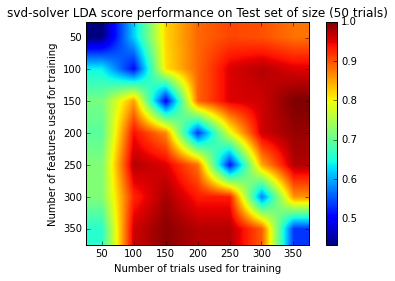

In [6]:
for solver in ['svd']:#,'lsqr']:
    # init the results matrix with all the scores for a particular solver
    result_matrix = np.zeros((7,7))
    # iterate through a number of features to be selected for training from the whole dataset
    for features,random_picks in enumerate([50,100,150,200,250,300,350]):
        # iterate through a number of trials to be selected for training
        for trials,train_trials in enumerate([50,100,150,200,250,300,350]):
            # list of lda scores for all the different number of trials of the current selected features in that iteration
            lda_scores = []
            # set the size of the test trials
            test_trials=50
#             print('Random Features '+str(random_picks) +', Trained Trials '+str(train_trials))# +'\nTested Trials '+str(test_trials))
            # iterate through the 3 different versions of datasets and calculate their mean lda score 
            # (versions do not differ a lot, similar results can be produced if we only use 1 version)
            for version in np.arange(3):
                # Load datasets and their respective labels: shape(trials X time X features)
                data = np.load('trial_data_'+str(version)+".npy")
                data_labels = np.load('trial_labels_'+str(version)+'.npy')
                # pick random features
                random_features = np.random.choice(data.shape[2], random_picks, replace=False)
                # create dataset with train and test sets with a specific amount of random features
                dataset = split_train_test(data, data_labels, features=random_features, train_size=train_trials, test_size=test_trials)
                # set the train and test sets by taking the average of second axes (time)
                train_set = np.mean(dataset['train'], axis=1)
                test_set = np.mean(dataset['test'], axis=1)
                lda_score = compute_performance_LDA(train_set, dataset['train_labels'],
                                                    test_set, dataset['test_labels'],
                                                    solver_method=solver)
                lda_scores.append(lda_score)
            # add the mean of the 3 versions of the datasets in the final results matrix
            result_matrix[features,trials] = np.mean(lda_scores)
#             print(result_matrix[features,trials])
    # plot the final results matrix for that solver
    plt.figure()
    plt.imshow(result_matrix)
    plt.title(solver+"-solver LDA score performance on Test set of size (50 trials)")
    plt.xticks([0,1,2,3,4,5,6],[50,100,150,200,250,300,350])
    plt.yticks([0,1,2,3,4,5,6],[50,100,150,200,250,300,350])
    plt.xlabel("Number of trials used for training")
    plt.ylabel("Number of features used for training")
    plt.colorbar()